# Ejercicio Final Unidad 5. Daniel González Millán 


Trabajamos como científicos de datos para una empresa de retail que, debido al cambio en los hábitos de consumo de los clientes, está potenciando ampliamente el servicio de venta online. La empresa quiere realizar un modelo de aprendizaje automático para clasificar a los clientes en función de la probabilidad de generar ingresos al comprar en la web.

El objetivo es realizar una serie de acciones específicas para los clientes que es más probable que hagan compras en la web.

Para ello, la empresa ha ido recopilando datos con su herramienta de Google Analytics. Cuenta con datos de sesiones, cada una de ellas de un cliente distinto en un periodo de un año.

## Información de los datos

1. El conjunto de datos consta de diez atributos numéricos y ocho categóricos.
2. El atributo revenue puede ser usado como la etiqueta de la clase.
3. Administrative, administrative duration, informational, informational duration, product related y product related duration representan el número de diferentes tipos de páginas visitadas por el visitante en esa sesión y el tiempo total dedicado a cada una de estas categorías de páginas. Los valores de estas características se derivan de la información del URL de las páginas visitadas por el usuario y se actualizan en tiempo real cuando el usuario realiza una acción, por ejemplo, pasar de una página a otra.
4. Las características bounce rate, exit rate y page value representan las métricas medidas por Google Analytics para cada página del sitio de comercio electrónico. El valor de la característica bounce rate de una página web se refiere al porcentaje de visitantes que entran en el sitio desde esa página y luego salen (rebote) sin activar ninguna otra solicitud al servidor de análisis durante esa sesión. El valor de la característica exit rate para una página web específica se calcula como para todas las visitas a la página, el porcentaje que fueron las últimas en la sesión. La función Page Value representa el valor medio de una página web que un usuario ha visitado antes de completar una transacción de comercio electrónico.
5. La característica de special day indica la cercanía de la hora de visita del sitio a un día especial específico (por ejemplo, el Día de la Madre, San Valentín) en el que es más probable que las sesiones finalicen con una transacción. El valor de este atributo se determina teniendo en cuenta la dinámica del comercio electrónico, como la duración entre la fecha del pedido y la fecha de entrega. Por ejemplo, para San Valentín, este valor toma un valor distinto de 0 entre el 2 y el 12 de febrero, 0 antes y después de esta fecha a menos que esté cerca de otro día especial, y su valor máximo de 1 el 8 de febrero.
6. El conjunto de datos también incluye el sistema operativo, el navegador, la región, el tipo de tráfico, el tipo de visitante como visitante que regresa o como nuevo visitante, un valor booleano que indica si la fecha de la visita es de fin de semana, y el mes del año.


**1) Realización de un análisis de las variables del dataset de Google Analytics como pueden ser histogramas, boxplots, etc. Cualquier otro análisis es bienvenido, siempre explicándolo y con un sentido de negocio.**

**2) Tratamiento de los valores faltantes, outliers, etc., en caso de que los hubiese. Si hay valores con missings, habrá que eliminarlos con el método de Pandas llamado Dropna().a.**

**3) Tratamiento de categóricas, pasándolas a numéricas por medio de dummies, mapeándolas o utilizando un label encoder. Hay que justificar las operaciones que se realizan.**

**4) Si existe alguna variable que se necesite borrar, habrá que borrara y justificarlo.**

**5) Estandariza los datos.**

In [1]:
from IPython.core.display import display, HTML
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as skl
pd.options.display.max_columns = 500
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
import sklearn.metrics as metrics
from scipy.stats import boxcox, probplot, norm, shapiro
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from IPython.core.display import display, HTML
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import tree
import os, sys
import warnings
warnings.filterwarnings('ignore')


# Funciones a usar:

In [2]:
def comprueba_normalidad(df, return_type='axes', title='Comprobación de normalidad'):
    '''
    '''
    fig_tot = (len(df.columns))
    fig_por_fila = 3.
    tamanio_fig = 4.
    num_filas = int( np.ceil(fig_tot/fig_por_fila) )    
    plt.figure( figsize=( fig_por_fila*tamanio_fig+5, num_filas*tamanio_fig+2 ) )
    c = 0 
    shapiro_test = {}
    lambdas = {}
    for i, col in enumerate(df.columns):
        ax = plt.subplot(num_filas, fig_por_fila, i+1)
        probplot(x = df[df.columns[i]], dist=norm, plot=ax)
        plt.title(df.columns[i])
        shapiro_test[df.columns[i]] = shapiro(df[df.columns[i]])
    plt.suptitle(title)
    plt.show()
    shapiro_test = pd.DataFrame(shapiro_test, index=['Test Statistic', 'p-value']).transpose()
    return shapiro_test

def relaciones_vs_target(X, Y, return_type='axes'):
    fig_tot = (len(X.columns))
    fig_por_fila = 4.
    tamanio_fig = 4.
    num_filas = int( np.ceil(fig_tot/fig_por_fila) )    
    plt.figure( figsize=( fig_por_fila*tamanio_fig+5, num_filas*tamanio_fig+5 ) )
    c = 0 
    for i, col in enumerate(X.columns):
        plt.subplot(num_filas, fig_por_fila, i+1)
        sns.scatterplot(x=X[col], y=Y)
        plt.title( '%s vs %s' % (col, 'target') )
        plt.ylabel('Target')
        plt.xlabel(col)
    plt.show()

def represento_doble_hist(x_1, x_0, n_bins=11, title='', label_1='Clase 1', 
                          label_0='Clase 0', normed=0):
    bins = n_bins
    plt.hist(x_1, bins, normed = normed, alpha=0.5, label=label_1, color='red')    
    plt.hist(x_0, bins, normed = normed, alpha=0.5, label=label_0, color='green')
    plt.title(title)
    plt.legend(loc='best') 
    
def hist_pos_neg_feat(x, y, normed=0, nbins=11, targets=(0,1)):
    fig_tot = len(x.columns)
    fig_tot_fila = 4.; fig_tamanio = 4.
    num_filas = int( np.ceil(fig_tot/fig_tot_fila) )
    plt.figure( figsize=( fig_tot_fila*fig_tamanio+2, num_filas*fig_tamanio+2 ) )
    target_neg, target_pos = targets
    for i, feat in enumerate(x.columns):
        plt.subplot(num_filas, fig_tot_fila, i+1);
        plt.title('%s' % feat)
        idx_pos = y == target_pos
        idx_neg= y == target_neg
        represento_doble_hist(x[feat][idx_pos].values, x[feat][idx_neg].values, nbins, 
                   normed = normed, title=('%s' % feat))

In [3]:
XY = pd.read_csv('./online_shoppers_intention.csv', sep=',', index_col=False)
print(u'- El número de filas en el dataset es: {}'.format(XY.shape[0]))
print(u'- El número de columnas en el dataset es: {}'.format(XY.shape[1]))
print(u'- Nombres de las variables: {}'.format(list(XY.columns)))
XY[:2]

- El número de filas en el dataset es: 12330
- El número de columnas en el dataset es: 18
- Nombres de las variables: ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend', 'Revenue']


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.0,0.2,0.2,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,0.0,0.0,0.0,2.0,64.0,0.0,0.1,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False


In [4]:
XY.isnull().sum()

Administrative             14
Administrative_Duration    14
Informational              14
Informational_Duration     14
ProductRelated             14
ProductRelated_Duration    14
BounceRates                14
ExitRates                  14
PageValues                  0
SpecialDay                  0
Month                       0
OperatingSystems            0
Browser                     0
Region                      0
TrafficType                 0
VisitorType                 0
Weekend                     0
Revenue                     0
dtype: int64

In [5]:
# Como el número de NAs es muy pequeño y tampoco tenemos forma alfuna de recuperar esa información faltante,
# vamos a proceder a eliminar esos registros
XY_clean = XY.dropna()

In [6]:
print(u'- El número de filas en el dataset es: {}'.format(XY_clean.shape[0]))
print('- El número de nulos en el dataset es: ')
XY_clean.isnull().sum()

- El número de filas en el dataset es: 12316
- El número de nulos en el dataset es: 


Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [7]:
XY_clean.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000
mean,2.317798,80.906176,0.503979,34.506387,31.763884,1196.037057,0.022152,0.043003,5.895952,0.061497,2.124147,2.357584,3.148019,4.070477
std,3.322754,176.860432,1.270701,140.825479,44.490339,1914.372511,0.048427,0.048527,18.577926,0.199020,0.911566,1.718028,2.402211,4.024598
min,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,185.000000,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,8.000000,0.000000,0.000000,18.000000,599.766190,0.003119,0.025124,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.500000,0.000000,0.000000,38.000000,1466.479902,0.016684,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


Voy a guardar las variables numéticas en una sola variable, ya que voy a relazar modificaciones sobre ellas.

In [8]:
X_cuants = XY_clean[['Administrative','Informational','ProductRelated','BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']].copy()
X_cuants_final = XY_clean[['Administrative','Administrative_Duration','Informational','Informational_Duration','ProductRelated','ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']].copy()

In [9]:
X_normalizado = (X_cuants-X_cuants.mean())/X_cuants.std()

In [10]:
X_normalizado[:2]

,Administrative,Informational,ProductRelated,BounceRates,ExitRates,PageValues,SpecialDay
0,-0.697553,-0.396615,-0.691473,3.672477,3.235240,-0.317363,-0.309001
1,-0.697553,-0.396615,-0.668997,-0.457439,1.174544,-0.317363,-0.309001


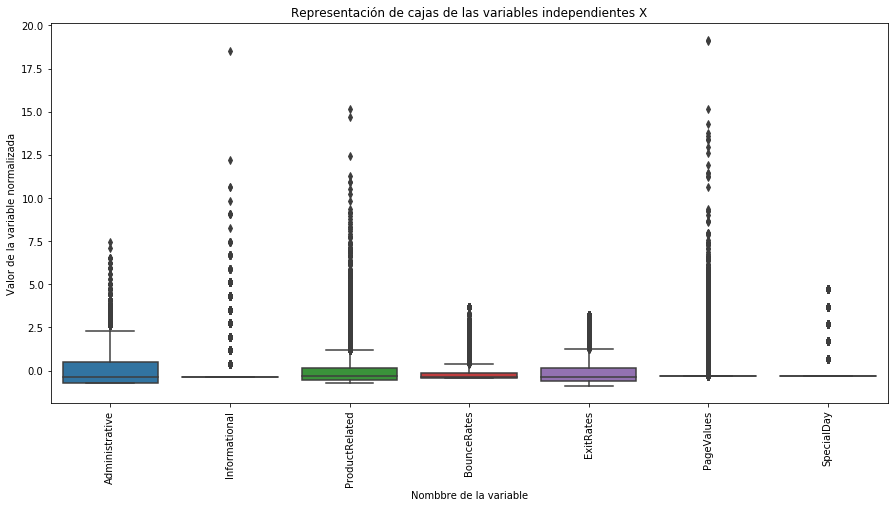

In [11]:
plt.figure(figsize=(15,7))
ax = sns.boxplot(data=X_normalizado)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title(u'Representación de cajas de las variables independientes X')
plt.ylabel('Valor de la variable normalizada')
_ = plt.xlabel('Nombbre de la variable')

Vemos que todas las variables tienen outliers.

# Histogramas

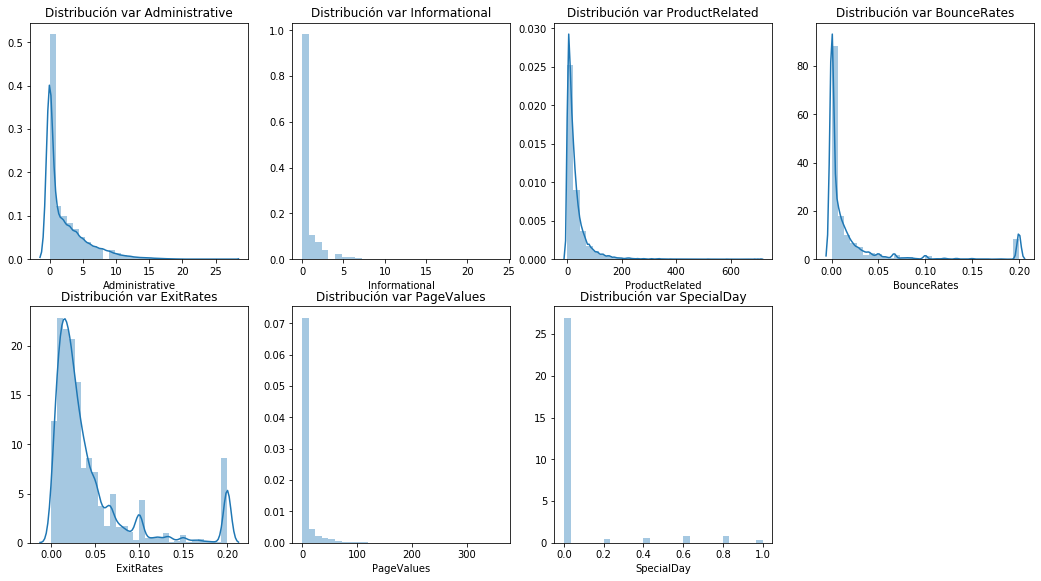

In [12]:
plt.figure(figsize=(18,20))
n = 0
for i, column in enumerate(X_cuants.columns):
    n+=1
    plt.subplot(4, 4, n)
    sns.distplot(X_cuants[column], bins=30)
    plt.title('Distribución var {}'.format(column))
plt.show()

Las variables no siguen distribuciones Gaussianas.

In [13]:
# En df uno las dos variables categóricas iniciales y las numéricas transformadas
XY_Final  =  pd.concat([XY_clean[['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend', 'Revenue']],X_cuants_final],axis=1)
XY_Final[:3]

,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay
0,Feb,1,1,1,1,Returning_Visitor,False,False,0.0,0.0,0.0,0.0,1.0,0.0,0.2,0.2,0.0,0.0
1,Feb,2,2,1,2,Returning_Visitor,False,False,0.0,0.0,0.0,0.0,2.0,64.0,0.0,0.1,0.0,0.0
2,Feb,4,1,9,3,Returning_Visitor,False,False,0.0,-1.0,0.0,-1.0,1.0,-1.0,0.2,0.2,0.0,0.0


Ahora voy a mapear las variables categóricas, empiezo por la variable mes

In [14]:
XY_clean['Month'].value_counts()

May     3363
Nov     2998
Mar     1894
Dec     1727
Oct      549
Sep      448
Aug      433
Jul      432
June     288
Feb      184
Name: Month, dtype: int64

In [15]:
dic_month = {'Feb':2, 'Mar':3, 'May': 5, 'June':6, 'Jul':7,
       'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11,'Dec': 12}
XY_clean['Month'].replace(dic_month, inplace=True)

Lo mismo con VisitorType

In [16]:
XY_clean['VisitorType'].value_counts()

Returning_Visitor    10537
New_Visitor           1694
Other                   85
Name: VisitorType, dtype: int64

In [17]:
dic_visitor = {'Other':0, 'New_Visitor':1, 'Returning_Visitor': 2}
XY_clean['VisitorType'].replace(dic_visitor, inplace=True)

Y con las varaibles de tipo bool.

In [18]:
dict_bool = {False:0, True:1}
XY_clean['Weekend'].replace(dict_bool, inplace=True)
XY_clean['Revenue'].replace(dict_bool, inplace=True)

## Division en features X + target Y 

In [19]:
# Divide los datos en features y target 
X = XY_clean.drop('Revenue', axis=1)
Y = XY_clean['Revenue']

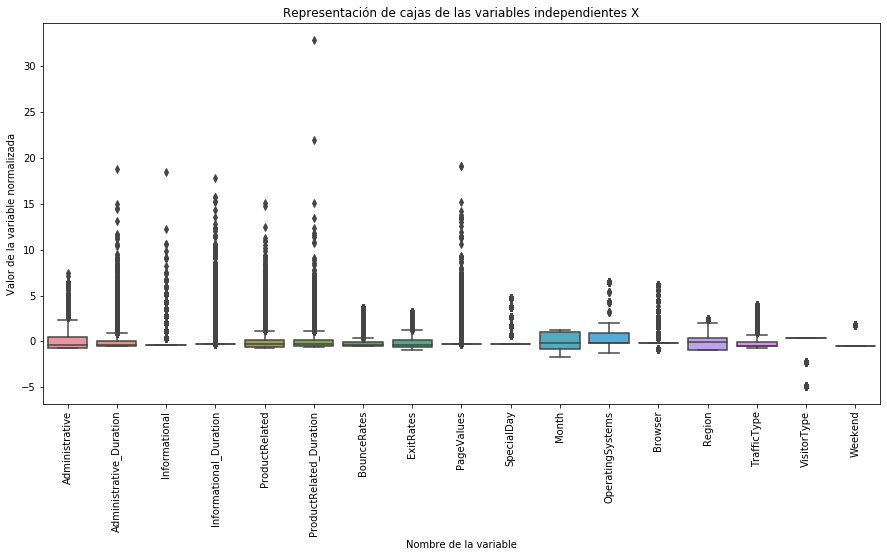

In [20]:
# Represento los boxplot
# Normalizo para tener rangos comparables en las features. No se normaliza la target
X_normalizado = (X-X.mean())/X.std()
plt.figure(figsize=(15,7))
ax = sns.boxplot(data=X_normalizado)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title(u'Representación de cajas de las variables independientes X')
plt.ylabel('Valor de la variable normalizada')
_ = plt.xlabel('Nombre de la variable')

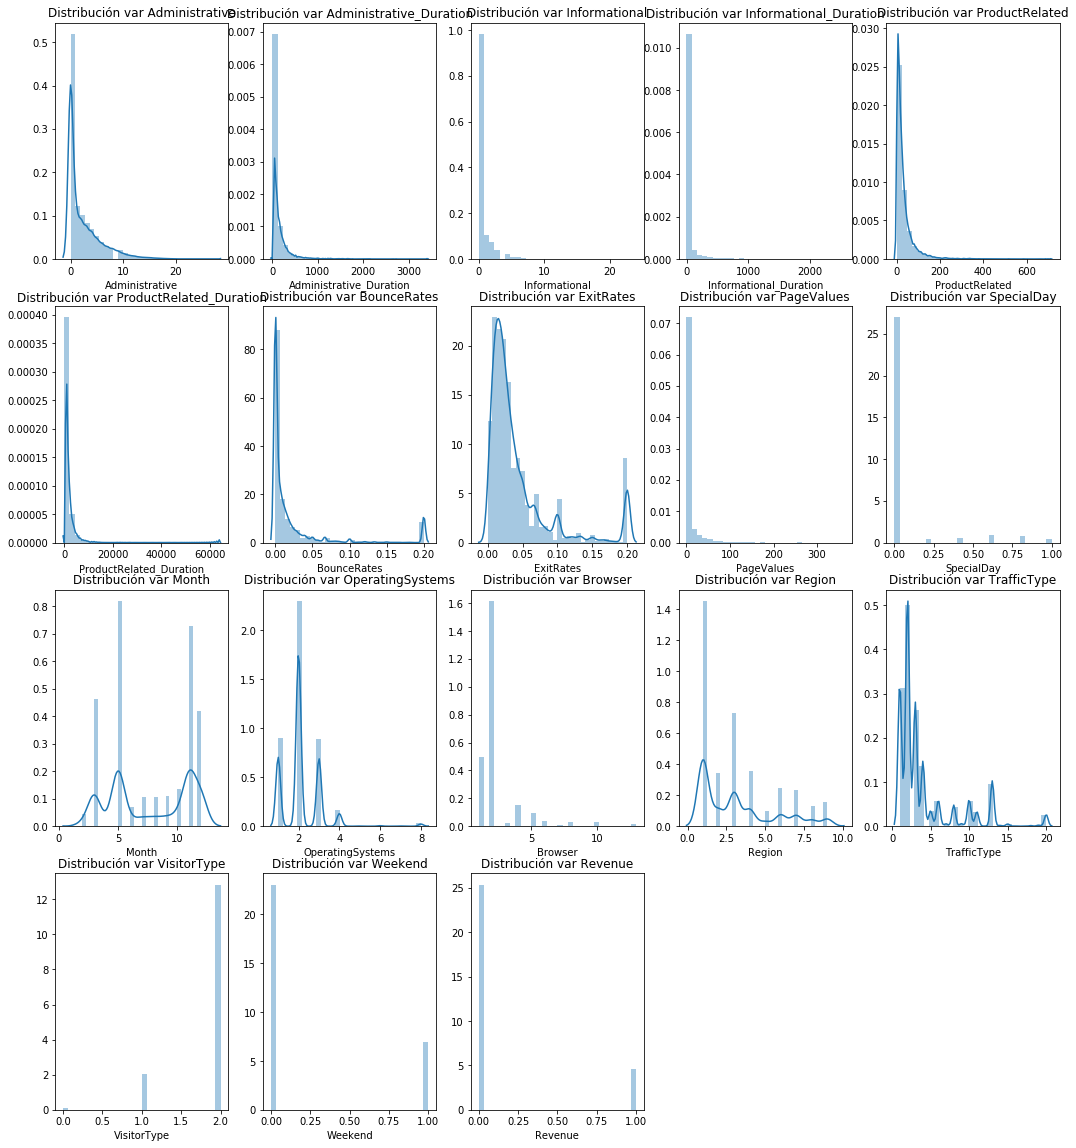

In [21]:
# Representa los histogramas de los datos completos, incluyendo la target
plt.figure(figsize=(18,20))
n = 0
for i, column in enumerate(XY_clean.columns):
    n+=1
    plt.subplot(4, 5, n)
    sns.distplot(XY_clean[column], bins=30)
    plt.title('Distribución var {}'.format(column))
plt.show()

## Relación variable vs target: 

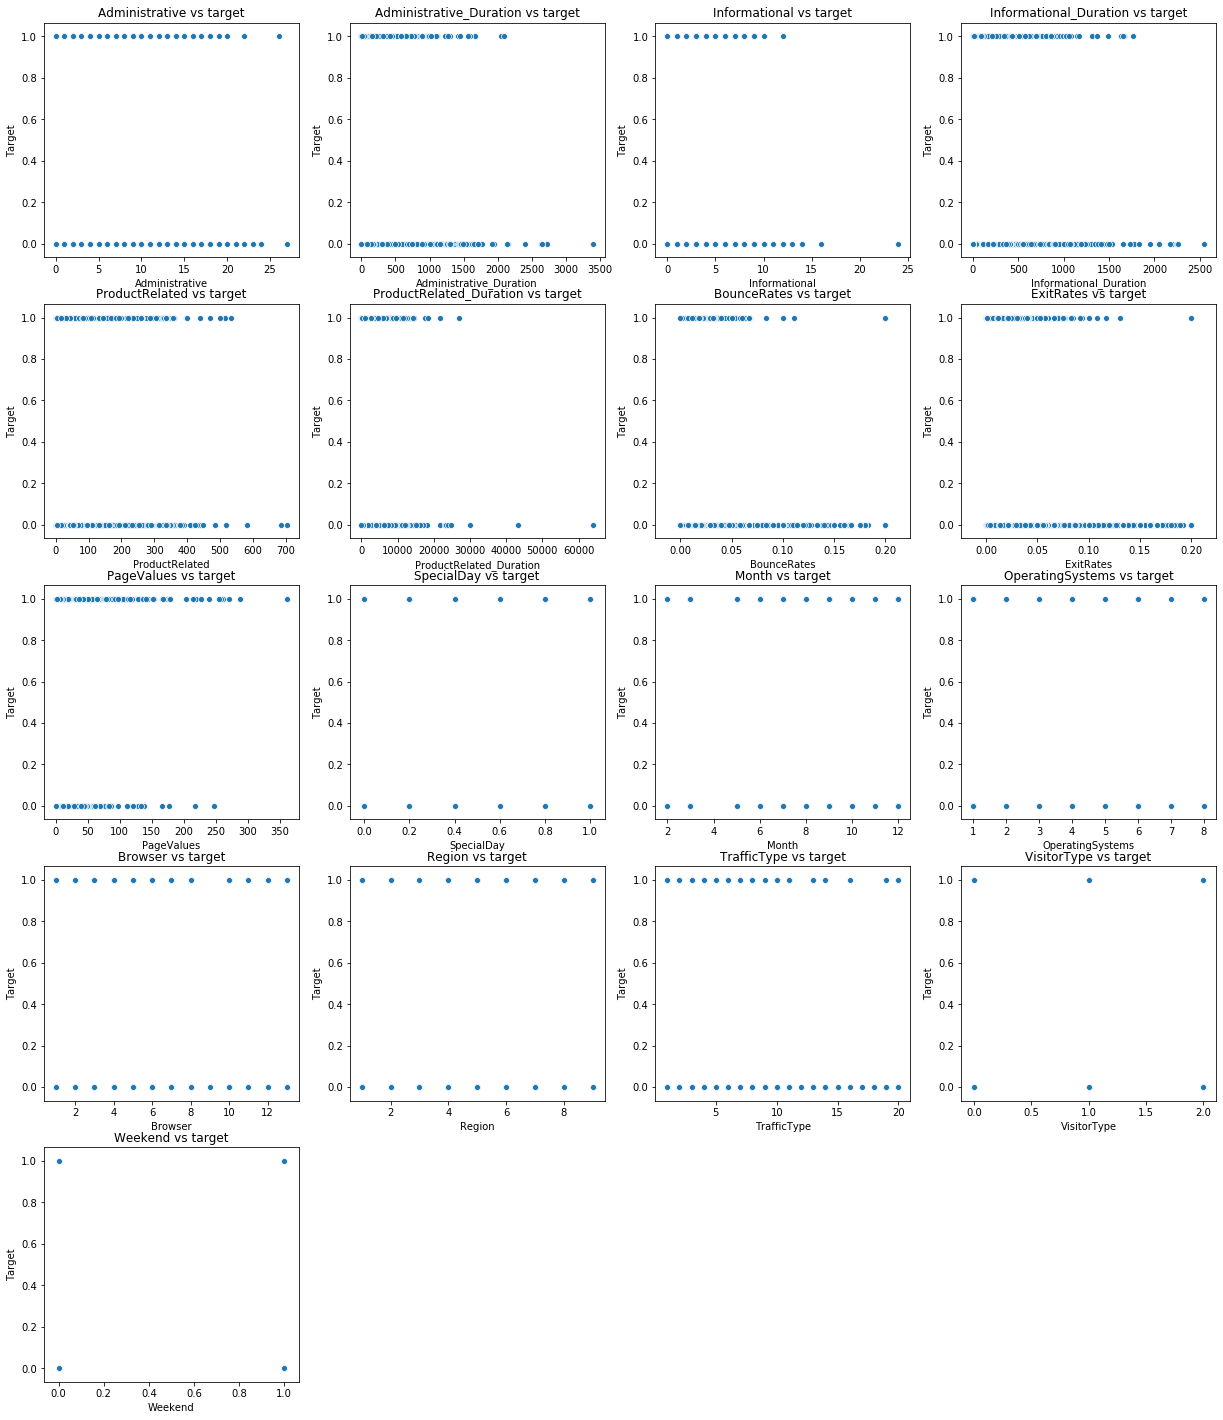

In [22]:
# Representa la relación de las variables independientes y la dependiente
relaciones_vs_target(X, Y)

### Histogramas positivos-negativos

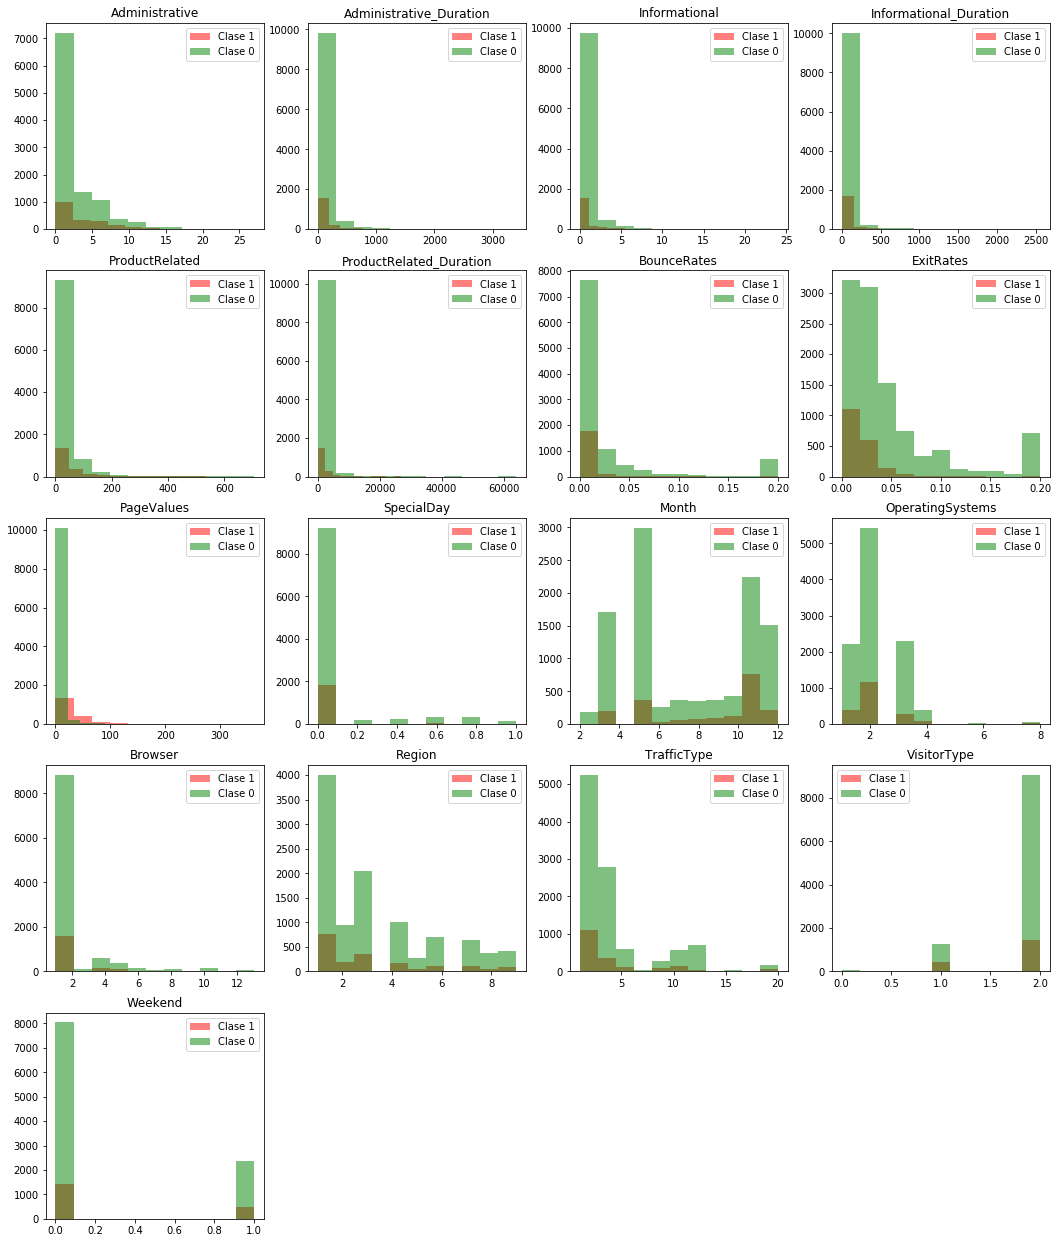

In [23]:
# Represento histogramas separando las features por el valor de la target
hist_pos_neg_feat(X,Y)

### Correlation matrix

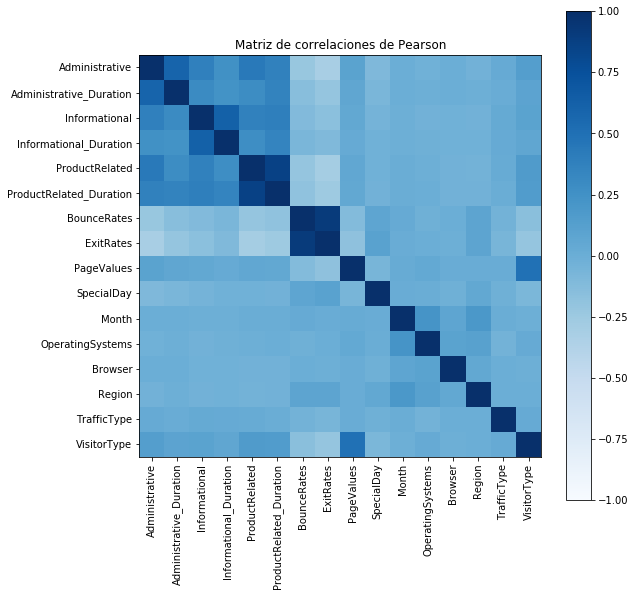

In [24]:
# Represento la matriz de correlaciones para observar qué variables tienen más correlación entre ellas
matriz_correlaciones = XY.corr(method='pearson')
n_ticks = len(XY.columns)
plt.figure( figsize=(9, 9) )
plt.xticks(range(n_ticks), XY.columns, rotation='vertical')
plt.yticks(range(n_ticks), XY.columns)
plt.colorbar(plt.imshow(matriz_correlaciones, interpolation='nearest', 
                            vmin=-1., vmax=1., 
                            cmap=plt.get_cmap('Blues')))
_ = plt.title('Matriz de correlaciones de Pearson')

## Variables con mayor correlación con la target:

In [25]:
# Obtengo las variables más y menos correlacionadas con la target
correlaciones_target = matriz_correlaciones.values[ -1, : -1]
indices_inversos =  abs(correlaciones_target[ : ]).argsort()[ : : -1]
diccionario = {}
for nombre, correlacion in zip( X.columns[indices_inversos], list(correlaciones_target[indices_inversos] ) ):
    diccionario[nombre] = correlacion
pd.DataFrame.from_dict(diccionario, orient='index', columns=['Correlación con la target'])

,Correlación con la target
PageValues,0.492569
ExitRates,-0.206886
ProductRelated,0.158280
ProductRelated_Duration,0.152130
BounceRates,-0.150621
Administrative,0.138631
Informational,0.095085
Administrative_Duration,0.093395
SpecialDay,-0.082305
Informational_Duration,0.070250


## Estandarización de los datos previa: 

In [26]:
# Estandarizo los datos para la regesión logística y el modelo de redes neuronales.
# No es necesario hacerlo para el modelo de árboles, pero no perjudica
obj_escalar = StandardScaler()
X_estandarizado = obj_escalar.fit_transform(X)

**6) Dividir los datos en train y en test. Con los datos de train se pretende ajustar modelos con CrossValidation y GridSearch.**

* Utilizar un modelo lineal. Entre los modelos lineales están las regresiones logísticas, las regresiones lineales, etc.
* Utilizar un modelo de redes neuronales.
* Utilizar cualquier otro modelo de clasificación.

**7) Optimizar algún parámetro de cada modelo utilizando CrossValidation y GridSearch, o de la forma que se estime oportuna, siempre justificándolo.**

**8) Elegir el mejor modelo de los tres según la métrica ROC en CrossValidation. Predecir Test y obtener una métrica estimada.**

**9) Umbralizar las probabilidades utilizando el umbral que maximice el área bajo la curva ROC.**

## División en train y test: 

In [27]:
# Divido los datos en train y test, con un 20 % de tamaño de test
X_train, X_test, Y_train, Y_test = train_test_split(X_estandarizado, Y, test_size=0.2, random_state=0)

# Modelo lineal (Regresión logística)

### Aplicamos un modelo de clasificación lineal optimizando C y class_weight con GridSearch 

In [28]:
modelo = LogisticRegression()
modelo.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
# Predigo las probabilidades en el conjunto de Test y calcula la métrica ROC AUC
y_test_pred_prob = modelo.predict_proba(X_test)
metrics.roc_auc_score(Y_test, y_test_pred_prob[:,1])

0.8842766670742643

### Optimiza los parámetros:

In [30]:
#La métrica a optimizar queremos que sea la roc_auc
modelo = LogisticRegression()
parametros = {"C": [0., 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08,0.09], 
              "class_weight":['balanced', None]}
modelo_gs = GridSearchCV(modelo, param_grid=parametros,
                         cv = 5, scoring='roc_auc')
modelo_gs.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07,
                               0.08, 0.09],
                         'class_weight': ['balanced', None]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [31]:
# Imprimo los mejores parámetros
print(modelo_gs.best_params_, "\nROC AUC: {}".format(round(modelo_gs.best_score_,2)))

{'C': 0.09, 'class_weight': 'balanced'} 
ROC AUC: 0.9


In [32]:
df_search = pd.DataFrame.from_dict(modelo_gs.cv_results_)

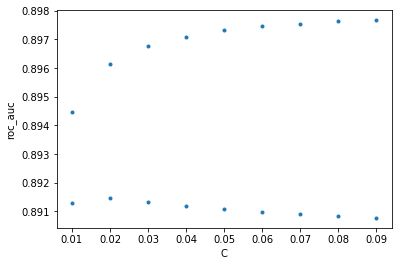

In [33]:
# Represento la métrica en función del valor de uno de los parámetros
plt.xlabel('C')
plt.ylabel('roc_auc')
_ = plt.plot( df_search['param_C'], df_search['mean_test_score'], '.')

In [34]:
# Predigo las probabilidades en el conjunto de Test y calcula la métrica ROC AUC
y_test_pred_prob = modelo_gs.predict_proba(X_test)
metrics.roc_auc_score(Y_test, y_test_pred_prob[:,1])

0.893558429118774

Hemos pasado de 0.8842766670742643 a 0.893558429118774, por lo que ha habido algo de mejora al optimizar los parámetros.

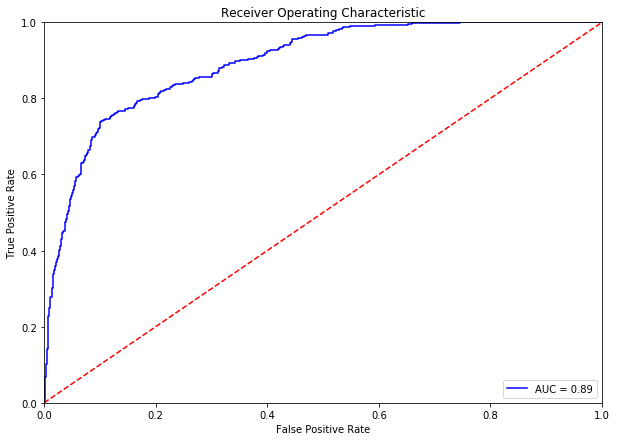

In [35]:
# Represento la curva ROC de las predicciones en Test
preds = y_test_pred_prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

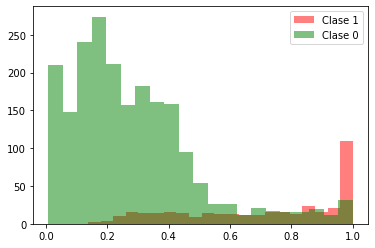

In [36]:
# Representa los histogramas de probabilidad de las predicciones en Test
y_test_pred_prob = modelo_gs.predict_proba(X_test)
y_test_pred_prob_pos = y_test_pred_prob[np.where(Y_test == 1)[0]]
y_test_pred_prob_neg = y_test_pred_prob[np.where(Y_test == 0)[0]]

represento_doble_hist(y_test_pred_prob_pos[:, 1], y_test_pred_prob_neg[:, 1], n_bins=21, normed=0)

In [37]:
# Calcula las sensitividades en función a los umbrales anteriores
sensitividades = {}
for umbral in [0.1, 0.2, 0.3, 0.5, 0.6, 0.8]:
    y_umbralizadas = 1*(y_test_pred_prob[:, 1] > umbral)
    sensitividades[umbral] = metrics.recall_score(Y_test, y_umbralizadas)
sensitividades

{0.1: 1.0,
 0.2: 0.9893617021276596,
 0.3: 0.9148936170212766,
 0.5: 0.7420212765957447,
 0.6: 0.651595744680851,
 0.8: 0.48404255319148937}

In [38]:
precisiones = {}
for umbral in [0.1, 0.2, 0.3, 0.5, 0.6, 0.8,0.9]:
    y_umbralizadas = 1*(y_test_pred_prob[:, 1] > umbral)
    precisiones[umbral] = metrics.precision_score(Y_test, y_umbralizadas)
precisiones

{0.1: 0.17744218971212836,
 0.2: 0.23679185232336092,
 0.3: 0.29578675838349094,
 0.5: 0.5602409638554217,
 0.6: 0.6049382716049383,
 0.8: 0.6842105263157895,
 0.9: 0.7486631016042781}

In [39]:
# Calculo las métricas accuracy, sensitividad, predición y la matriz de confusión con el umbral 0.5
y_umbralizadas = 1*(y_test_pred_prob[:, 1] > 0.5)
print(u"Matriz de confusión\n", metrics.confusion_matrix(Y_test, y_umbralizadas))
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(Y_test, y_umbralizadas),2)))  
print("Sensitividad\t{}".format(round(metrics.recall_score(Y_test, y_umbralizadas),2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(Y_test, y_umbralizadas),2))) 

Matriz de confusión
 [[1869  219]
 [  97  279]]

Accuracy	0.87
Sensitividad	0.74
Precisión	0.56


# Modelo de redes neuronales

En este problema vamos a hacer uso de la librería **sklearn**. Esta librería cuenta con un clasificador llamado *MLPClassifier*, el cual es lo que se denomina un Multi-layer Perceptron Classifier.

Esta es la configuración más común y estándard de las redes neuronales. Cuentan con una capa de entrada, una de salida y múltiples capas ocultas. Se trata de una arquitectura de red neuronal **fully-connected**, es decir, las neuronas de cada capa se conectan a todas las neuronales de las capas anteriores y de las siguientes. En la imagen a continuación podéis ver un ejemplo de este tipo de redes neuronales.

In [40]:
modelo = MLPClassifier()
parametros = {'solver': ['lbfgs'], 
              'max_iter': [100,200,300,500], # Iteraciones máximas en cada red
              'alpha': 10.0 ** -np.arange(1, 3), # Parámetro de regularización L2 para evitar sobreajuste
              'hidden_layer_sizes':np.arange(30, 35), # Número de neuronas en cada capa
              'random_state':[0]}

In [41]:
modelo_gs = GridSearchCV(modelo, param_grid=parametros, cv = 3, 
                         scoring='roc_auc', n_jobs=-1, verbose=10)
modelo_gs.fit(X_train, Y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.3min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state...e,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': array([

In [42]:
print(modelo_gs.best_params_, "\nROC AUC: {}".format(round(modelo_gs.best_score_,2)))

{'alpha': 0.1, 'hidden_layer_sizes': 31, 'max_iter': 100, 'random_state': 0, 'solver': 'lbfgs'} 
ROC AUC: 0.9


### Mejores parámetros

Igual que en el resto de modelos, obtenemos los mejores parámetros encontrados y ajustamos un modelo con esos parámetros:

In [43]:
mejor_modelo = MLPClassifier(**modelo_gs.best_params_, verbose=10)

In [44]:
mejor_modelo.fit(X_train, Y_train)

MLPClassifier(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=31, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=100,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=10,
              warm_start=False)

In [45]:
#Análisis de las predicciones:
y_test_pred_prob = mejor_modelo.predict_proba(X_test) 
y_test_pred_prob_pos = y_test_pred_prob[np.where(Y_test == 1)[0]]
y_test_pred_prob_neg = y_test_pred_prob[np.where(Y_test == 0)[0]]

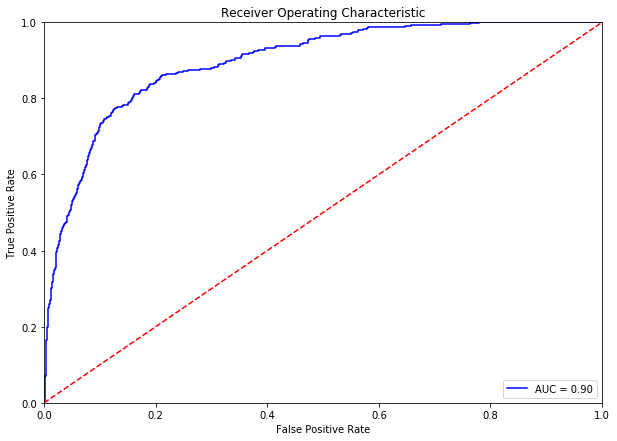

In [46]:
preds = y_test_pred_prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

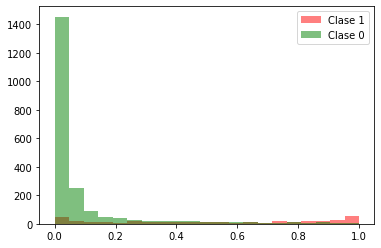

In [47]:
represento_doble_hist(y_test_pred_prob_pos[:, 1], y_test_pred_prob_neg[:, 1], n_bins=21, normed=0)

Umbralizo las predicciones

In [48]:
umbral = 0.5
y_umbralizadas = 1*(y_test_pred_prob[:, 1] > umbral)

In [49]:
print(u"Matriz de confusión\n", metrics.confusion_matrix(Y_test, y_umbralizadas))
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(Y_test, y_umbralizadas),2)))  
print("Sensitividad\t{}".format(round(metrics.recall_score(Y_test, y_umbralizadas),2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(Y_test, y_umbralizadas),2)))  

Matriz de confusión
 [[1985  103]
 [ 181  195]]

Accuracy	0.88
Sensitividad	0.52
Precisión	0.65


# Cualquier otro modelo de clasificación (Árbol de decisión)

In [50]:
depth = 5

In [51]:
clf = DecisionTreeClassifier(max_depth = depth)

In [52]:
clf.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [53]:
print(' - Accuracy media en el grupo de train: {}'.format(clf.score(X_train, Y_train)))
print(' - Accuracy media en el grupo de test: {}'.format(clf.score(X_test, Y_test)))

 - Accuracy media en el grupo de train: 0.9093585058871295
 - Accuracy media en el grupo de test: 0.9021915584415584


In [54]:
clas = DecisionTreeClassifier() 

In [55]:
params = {"max_depth": range(3,20)}

In [56]:
clf_opt = GridSearchCV(clas, params, cv =3)

In [57]:
clf_opt.fit(X_train, Y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': range(3, 20)}, pre_dispatch='2*n_jobs',


In [58]:
print(' - Accuracy media en el grupo de train: {}'.format(clf_opt.score(X_train, Y_train)))
print(' - Accuracy media en el grupo de test: {}'.format(clf_opt.score(X_test, Y_test)))

 - Accuracy media en el grupo de train: 0.9093585058871295
 - Accuracy media en el grupo de test: 0.9030032467532467


Diagrama de árbol con las reglas del árbol de decisión

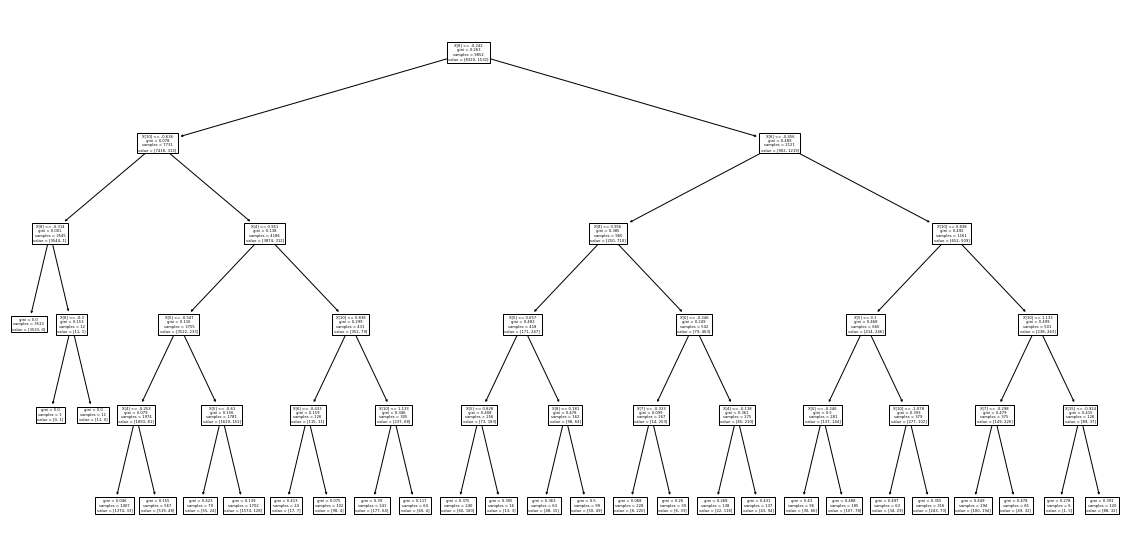

In [59]:
fig, ax = plt.subplots(figsize = (20,10))
_ = tree.plot_tree(clf, )
plt.show()

In [60]:
#Análisis de las predicciones:
y_test_pred_prob = clf_opt.predict_proba(X_test) 
y_test_pred_prob_pos = y_test_pred_prob[np.where(Y_test == 1)[0]]
y_test_pred_prob_neg = y_test_pred_prob[np.where(Y_test == 0)[0]]

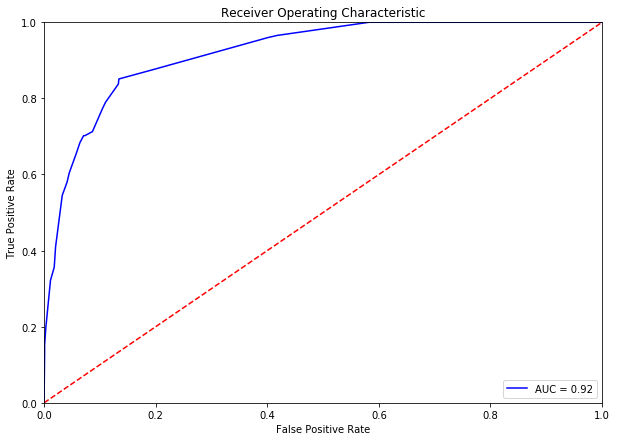

In [61]:
preds = y_test_pred_prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

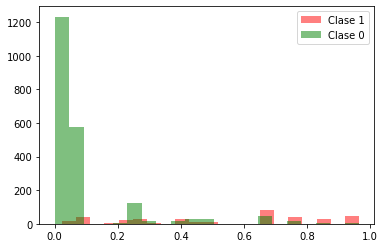

In [62]:
represento_doble_hist(y_test_pred_prob_pos[:, 1], y_test_pred_prob_neg[:, 1], n_bins=21, normed=0)

In [63]:
umbral = 0.5
y_umbralizadas = 1*(y_test_pred_prob[:, 1] > umbral)

In [64]:
print(u"Matriz de confusión\n", metrics.confusion_matrix(Y_test, y_umbralizadas))
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(Y_test, y_umbralizadas),2)))  
print("Sensitividad\t{}".format(round(metrics.recall_score(Y_test, y_umbralizadas),2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(Y_test, y_umbralizadas),2))) 

Matriz de confusión
 [[2020   68]
 [ 171  205]]

Accuracy	0.9
Sensitividad	0.55
Precisión	0.75


* Si la empresa busca detectar sí o sí personas que van a acabar comprando, entonces su objetivo es optimizar la sensitividad, ya que no darán tanta importancia a los falsos positivos, por lo tanto, nos quedaríamos con la regresión logística en este caso.

* Por otro lado, si lo que buscan es detectar con seguridad gente que va a comprar sus productos, lo que buscará la empresa es mejorar la precisión, por lo que escogerían el método de árboles, ya que es el que mayor precisión ofrece.